# Multi-Variate Pattern Analysis (MVPA)
## Computational Methods in Psychology (and Neuroscience)
### Psychology 4215/7215 --- Fall 2021
By: Per B. Sederberg, PhD



# Lesson Objectives

Upon completion of this lesson, students should have learned:

1. A quick fMRI primer
2. A dash through MRI preprocessing
3. Standard first-level GLM analysis
4. Multivariate pattern analysis


# Quick fMRI primer

![Arthurs & Boniface (2002)](http://2.bp.blogspot.com/-9q2tbD_ZcqE/VVcQZuAoVHI/AAAAAAAAFfo/AceWNBdSTm8/s1600/Fig2.png)
(From Arthurs & Boniface, 2002, *Trends in Neurosciences*)

## The slow hemodynamic response

![HRF](https://www.researchgate.net/profile/Markus-Barth-2/publication/224906750/figure/fig1/AS:393859306672150@1470914784606/Schematic-of-the-BOLD-hemodynamic-response-to-a-brief-stimulus-at-time-zero-After-the.png)

(From Barth and Poser, 2011)


## No neuroimaging modality is perfect...

... Trading off spatial and temporal resolution.

![Neuroimaging Modalities](http://2.bp.blogspot.com/-etqPHV_xz9s/VVZdaFj0WLI/AAAAAAAAFfQ/i_3DrkZ0wrY/s1600/fig6.jpg)

(From Sejnowski, Churchland and Movshon, 2014, *Nature Neuroscience*)

# New libraries to install

You're going to need some new libraries for processing neuroimaging data:

```bash
conda install -c conda-forge nilearn
```


In [5]:
# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats
import os

# import nilearn stuff
from nilearn import plotting, image

# Data from OpenNeuro

A free and open platform for validating and sharing BIDS-compliant MRI, PET, MEG, EEG, and iEEG data.

## Flanker task (event-related)

https://openneuro.org/datasets/ds000102/versions/00001

## fMRIPrep: A Robust Preprocessing Pipeline for fMRI Data

![](https://raw.githubusercontent.com/oesteban/fmriprep/38a63e9504ab67812b63813c5fe9af882109408e/docs/_static/fmriprep-workflow-all.png)

## fMRI data are HUGE!

If you'd like to download the preprocessed data to follow along, use this link:

https://virginia.box.com/s/79uda2ueln81wccy3dnxnxiz2paxywq0

Note that this is 345MB once unzipped!

## Verify some of the preprocessing

In [45]:
# load the grey matter segmented image
gm_img = image.load_img('fmriprep/sub-07/anat/sub-07_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz')
gm_img.shape

(193, 229, 193)

In [57]:
# load a run and check the shape
run2 = image.load_img('fmriprep/sub-07/func/sub-07_task-flanker_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
run2.shape

(65, 77, 49, 146)

/home/per/anaconda3/envs/smile/lib/python3.9/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



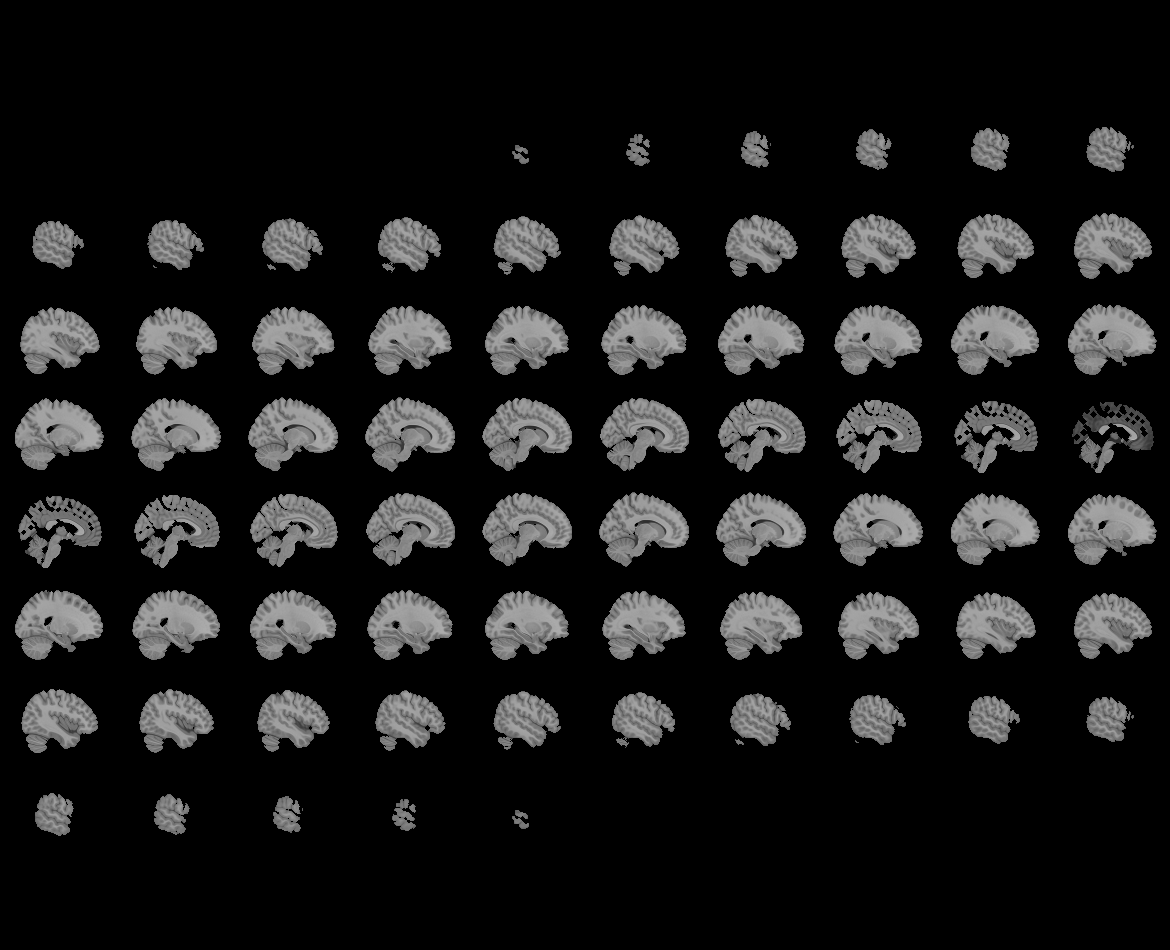
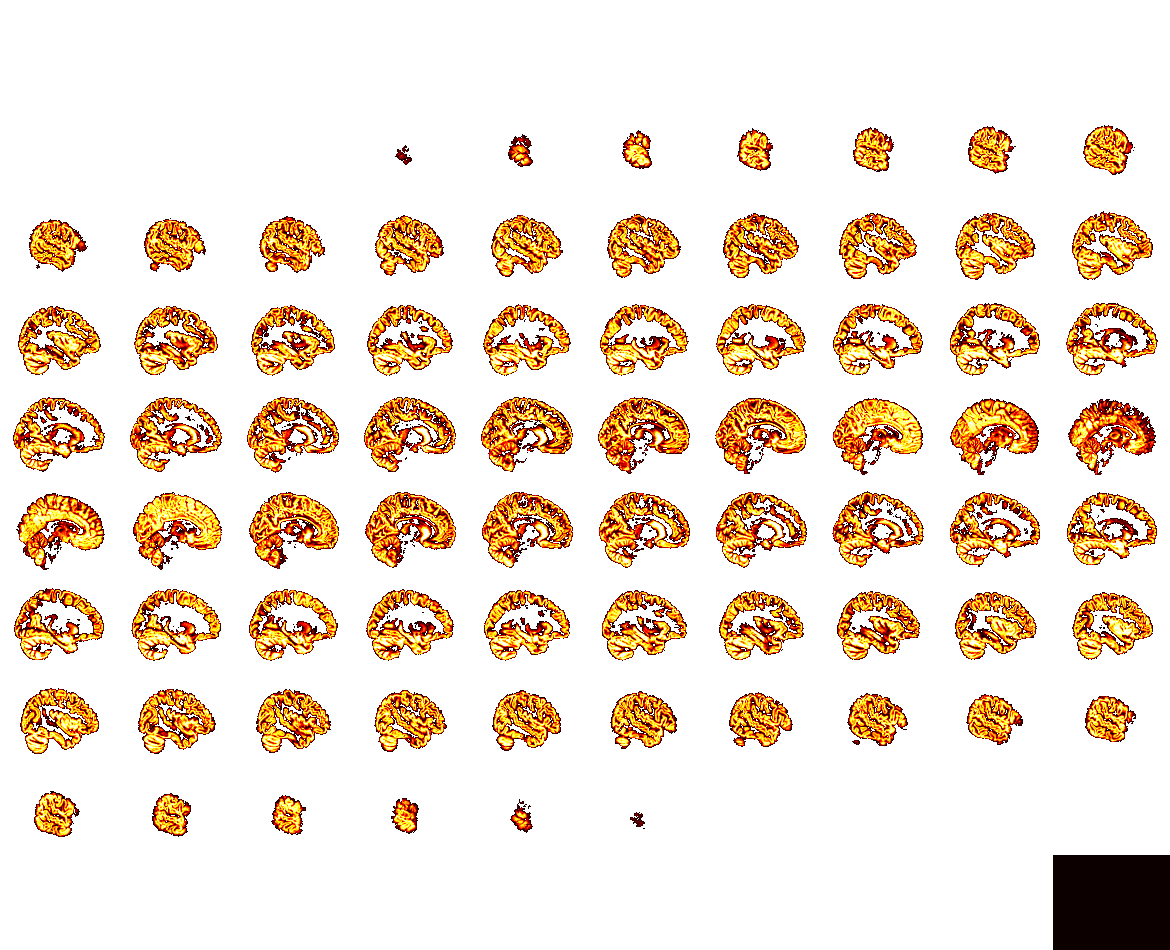

In [202]:
plotting.view_img(gm_img, symmetric_cmap=True,)

## Verify the behavioral data

In [189]:
# read in the behavioral data
df_1 = pd.read_table('fmriprep/sub-07/func/sub-07_task-flanker_run-1_events.tsv')
df_1['run'] = 1

df_2 = pd.read_table('fmriprep/sub-07/func/sub-07_task-flanker_run-2_events.tsv')
df_2['run'] = 2

df = pd.concat([df_1, df_2])

# fix the stim
df['Stimulus'] = [x.split('_')[0] for x in df['trial_type']]

# add log rt
df['log_rt'] = np.log(df['response_time'])
df.head()

,onset,duration,trial_type,response_time,correctness,StimVar,Rsponse,Stimulus,cond,run,log_rt
0,0.0,2.0,incongruent_correct,0.584,correct,2,1,incongruent,cond003,1,-0.537854
1,10.0,2.0,congruent_correct,0.492,correct,1,1,congruent,cond001,1,-0.709277
2,20.0,2.0,congruent_correct,0.408,correct,1,1,congruent,cond001,1,-0.896488
3,30.0,2.0,congruent_correct,0.347,correct,1,1,congruent,cond001,1,-1.058430
4,42.0,2.0,incongruent_correct,0.502,correct,2,1,incongruent,cond003,1,-0.689155


In [51]:
# test if they are slower on incongruent trials
stats.ttest_ind(df.loc[df['Stimulus']=='congruent', 'log_rt'],
                df.loc[df['Stimulus']=='incongruent', 'log_rt'])

Ttest_indResult(statistic=-6.85749756605286, pvalue=1.4910345320074454e-08)

- We see a significant slowdown for incongruent trials relative to congruent.

# First level Generalized Linear Model (GLM)

***Question: Is there any different in neural activity between congruent and incongruent conditions.***

## Generating a Design Matrix

- First step is to set up the independent variables.
- This will include the conditions, but also confounds to account for in the neural data.

In [88]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.plotting import plot_design_matrix

In [191]:
# read in the confounds
df_conf = pd.read_table('fmriprep/sub-07/func/sub-07_task-flanker_run-1_desc-confounds_timeseries.tsv')

# keep the most relevant
to_keep = ['csf',
'white_matter',
'tcompcor',
'std_dvars',
'dvars',
'framewise_displacement',
'rmsd',
't_comp_cor_00',
't_comp_cor_01',
't_comp_cor_02',
't_comp_cor_03',
't_comp_cor_04',
't_comp_cor_05',
'cosine00',
'cosine01',
'cosine02',
'non_steady_state_outlier00',
'non_steady_state_outlier01',
'trans_x',
'trans_x_derivative1',
'trans_x_power2',
'trans_x_derivative1_power2',
'trans_y',
'trans_y_derivative1',
'trans_y_derivative1_power2',
'trans_y_power2',
'trans_z',
'trans_z_derivative1',
'trans_z_power2',
'trans_z_derivative1_power2',
'rot_x',
'rot_x_derivative1',
'rot_x_derivative1_power2',
'rot_x_power2',
'rot_y',
'rot_y_derivative1',
'rot_y_power2',
'rot_y_derivative1_power2',
'rot_z',
'rot_z_derivative1',
'rot_z_derivative1_power2',
'rot_z_power2']
df_conf = df_conf[df_conf.columns[df_conf.columns.isin(to_keep)]]
df_conf = df_conf.dropna(axis=1)
df_conf.columns

Index(['csf', 'white_matter', 'tcompcor', 't_comp_cor_00', 't_comp_cor_01',
       't_comp_cor_02', 't_comp_cor_03', 't_comp_cor_04', 't_comp_cor_05',
       'cosine00', 'cosine01', 'cosine02', 'non_steady_state_outlier00',
       'non_steady_state_outlier01', 'trans_x', 'trans_x_power2', 'trans_y',
       'trans_y_power2', 'trans_z', 'trans_z_power2', 'rot_x', 'rot_x_power2',
       'rot_y', 'rot_y_power2', 'rot_z', 'rot_z_power2'],
      dtype='object')

In [192]:
# pull events and define onsets and durations
tr = 2.0  # repetition time is 2 second
n_scans = 146  # the acquisition comprises 128 scans
frame_times = np.arange(n_scans) * tr

events = pd.DataFrame({#'trial_type': ['ev'+str(x).zfill(2) for x in df[df['run']==1].index],
                       'trial_type': df[df['run']==1]['Stimulus'],
                       'onset': df[df['run']==1]['onset'],
                       'duration': df[df['run']==1]['duration']})
events

,trial_type,onset,duration
0,incongruent,0.0,2.0
1,congruent,10.0,2.0
2,congruent,20.0,2.0
3,congruent,30.0,2.0
4,incongruent,42.0,2.0
5,congruent,52.0,2.0
6,incongruent,64.0,2.0
7,incongruent,76.0,2.0
8,incongruent,88.0,2.0
9,congruent,102.0,2.0


In [193]:
# build the design matrix
hrf_model = 'glover'
X1 = make_first_level_design_matrix(
    frame_times, events, drift_model='polynomial', drift_order=3,
    add_regs=df_conf.to_numpy(), 
    add_reg_names=list(df_conf.columns), hrf_model=hrf_model)

<AxesSubplot:label='conditions', ylabel='scan number'>

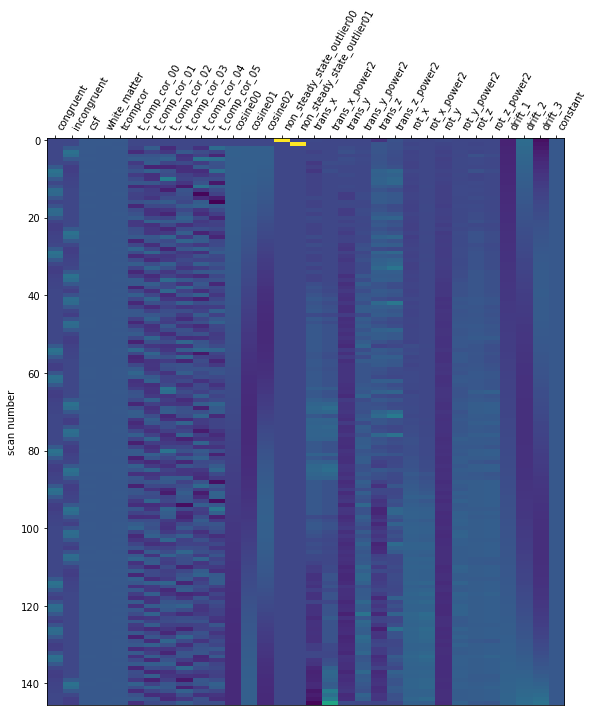

In [194]:
plot_design_matrix(X1)

## Fit the GLM


In [204]:

run = 1
epi_file = 'fmriprep/sub-07/func/sub-07_task-flanker_run-%d_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'%run
mask_file = 'fmriprep/sub-07/func/sub-07_task-flanker_run-%d_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'%run
fmri_glm = FirstLevelModel(t_r=tr,
                           mask_img=mask_file,
                           smoothing_fwhm=8)
fmri_glm = fmri_glm.fit(epi_file, design_matrices=X1)

In [205]:
contrast_matrix = np.eye(X1.shape[1])
contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(X1.columns)])
contrasts

{'congruent': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'incongruent': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'csf': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'white_matter': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tcompcor': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 't_comp_cor_00': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 't_comp_cor_01': array([0., 0., 0., 0., 0.,

In [206]:
zmap = fmri_glm.compute_contrast(contrasts['incongruent']-contrasts['congruent'])
zmap.shape

(65, 77, 49)

/home/per/anaconda3/envs/smile/lib/python3.9/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



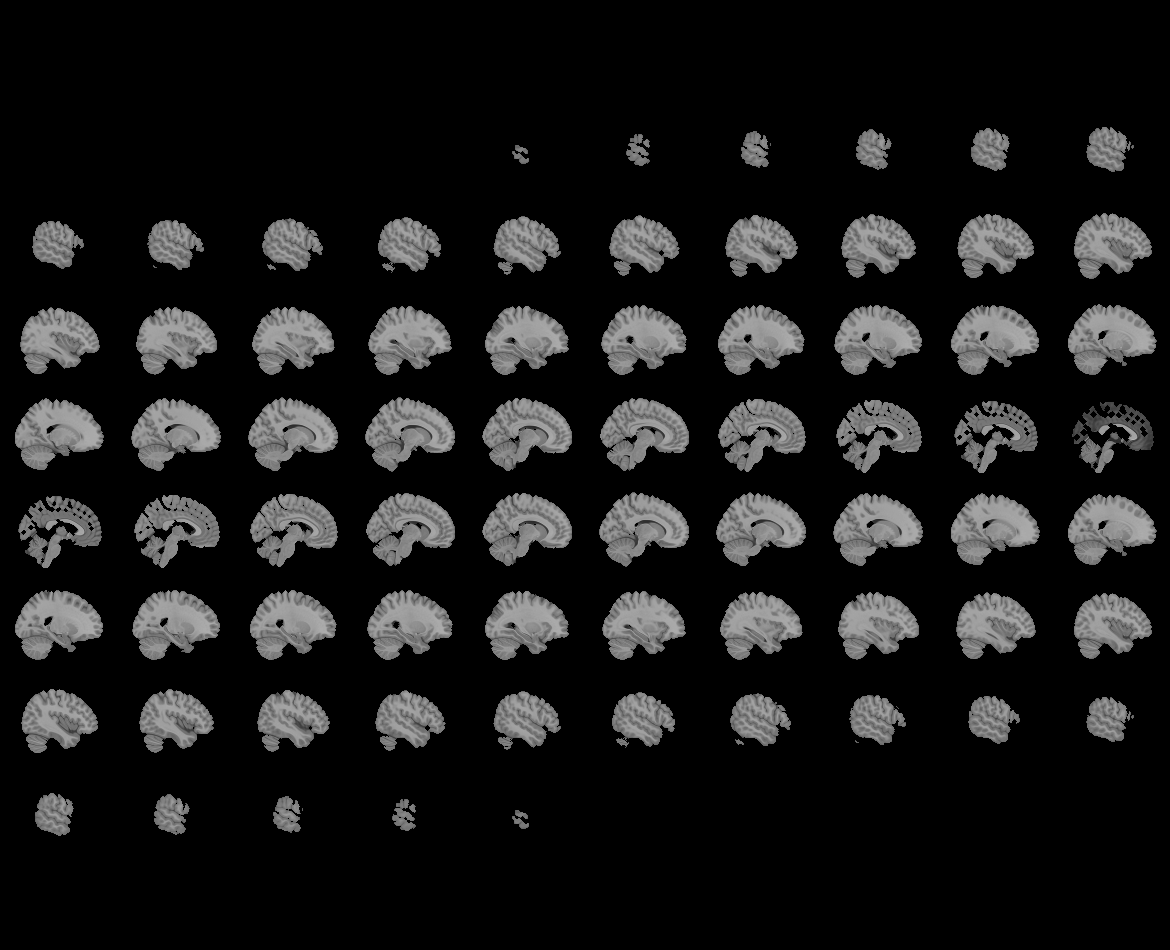
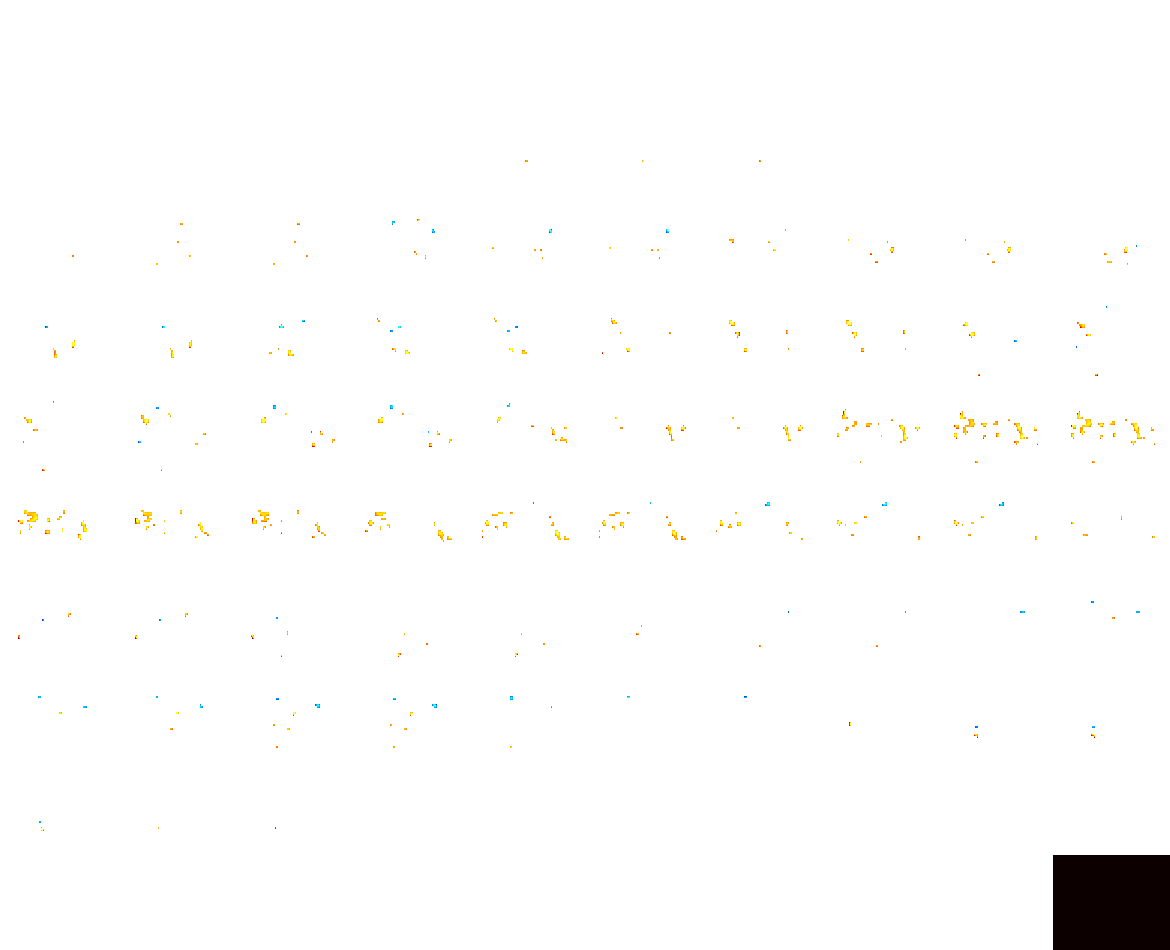

In [207]:
del hfig 
hfig = plotting.view_img(zmap,threshold=3.0,
                  symmetric_cmap=True,)
hfig

## GLM Results
- We see some Anterior Cingulate Cortex activation, as well as in visual attention regions for the incongruent relative to congruent trials.

# MVPA Analysis

- MVPA turns the standard regression on its head!

- Instead of predicting neural activity at each voxel with the conditions of your experiment, it predicts thoughts/processes based on patterns of neural activity.


## Single-trial Betas (STB)

- To get started, we'll want to calculate the neural response for each trial, not just for the conditions.

In [140]:
# create a mean mask from the two run masks
from nilearn.image import mean_img
from nilearn.masking import compute_epi_mask
mean_mask = mean_img(['fmriprep/sub-07/func/sub-07_task-flanker_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
          'fmriprep/sub-07/func/sub-07_task-flanker_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'])
mean_mask = compute_epi_mask(mean_mask)


In [209]:
# run the model for each run to get single trial betas
z_maps = []
conditions_label = []
session_label = []
for run in [1, 2]:
    # pull the events
    events = pd.DataFrame({'trial_type': ['ev'+str(x).zfill(2) 
                                          for x in df[df['run']==run].index],
                           'onset': df[df['run']==run]['onset'],
                           'duration': df[df['run']==run]['duration']})
    
    # make the design matrix
    conf_file = 'fmriprep/sub-07/func/sub-07_task-flanker_run-%d_desc-confounds_timeseries.tsv' % run
    df_conf = pd.read_table(conf_file)
    df_conf = df_conf[df_conf.columns[df_conf.columns.isin(to_keep)]]
    df_conf = df_conf.dropna(axis=1)

    X1 = make_first_level_design_matrix(
        frame_times, events, drift_model='polynomial', drift_order=3,
        add_regs=df_conf.to_numpy(), 
        add_reg_names=list(df_conf.columns), hrf_model=hrf_model)

    # fit the first level model
    epi_file = 'fmriprep/sub-07/func/sub-07_task-flanker_run-%d_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'%run
    #mask_file = 'fmriprep/sub-07/func/sub-07_task-flanker_run-%d_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'%run
    fmri_glm = FirstLevelModel(t_r=tr,
                               mask_img=mean_mask,
                               smoothing_fwhm=4)
    fmri_glm = fmri_glm.fit(epi_file, design_matrices=X1)

    # extract the z maps for each event
    z_maps.extend([fmri_glm.compute_contrast(contrast_) 
                   for contrast_ in events.trial_type.unique()])
    
    # extend the conditions and sessions
    stims = list(df.loc[df['run']==run, 'Stimulus'])
    conditions_label.extend(stims)
    session_label.extend([run]*len(stims))

<AxesSubplot:label='conditions', ylabel='scan number'>

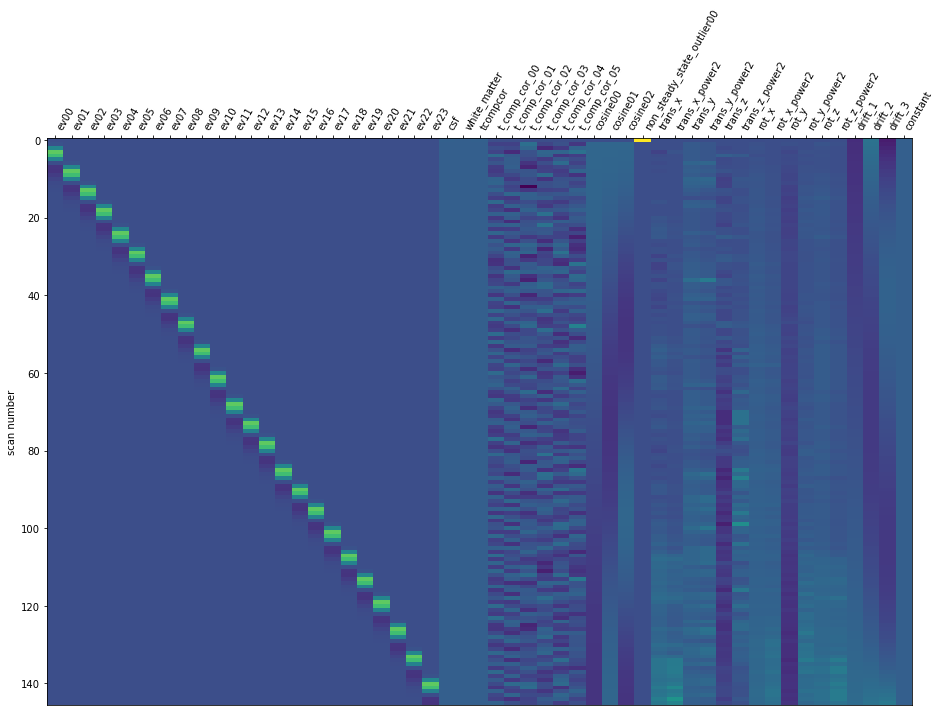

In [210]:
plot_design_matrix(X1)

## Build a decoder, then train and test it

In [225]:
from nilearn.decoding import Decoder
from sklearn.model_selection import LeaveOneGroupOut

# define and fit the decoder
decoder = Decoder(estimator='svc_l1', mask=mean_mask, standardize=False,
                  screening_percentile=10, cv=LeaveOneGroupOut())
decoder.fit(z_maps, conditions_label, groups=session_label)

# Return the corresponding mean prediction accuracy compared to chance
classification_accuracy = np.mean(list(decoder.cv_scores_.values()))
chance_level = 1. / len(np.unique(conditions_label))
print('Classification accuracy: {:.4f} / Chance level: {}'.format(
    classification_accuracy, chance_level))

Classification accuracy: 0.6111 / Chance level: 0.5


## What is it doing?

- Splitting the data into training and test sets based on the run.
- This is called Cross Validation (CV)

### Trianing
- For each training set, it will train the model to decode congruent vs. incongruent with the whole brain activity.
- There are far to many voxels (i.e., features) relative to the number of events (observations), so we have to use fancy tricks:
  - One is to penalize the weights so that the model finds *sparse* solutions
  - Another is to toss voxels that do not have much variance between conditions

### Testing
- After training on one half of the data, the model attempts to predict on the other half of the data that it hasn't seen.
- It saves out the accuracy of how well it was able to make these predictions, which we then report.

## Plotting the weights used to predict condition

/home/per/anaconda3/envs/smile/lib/python3.9/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



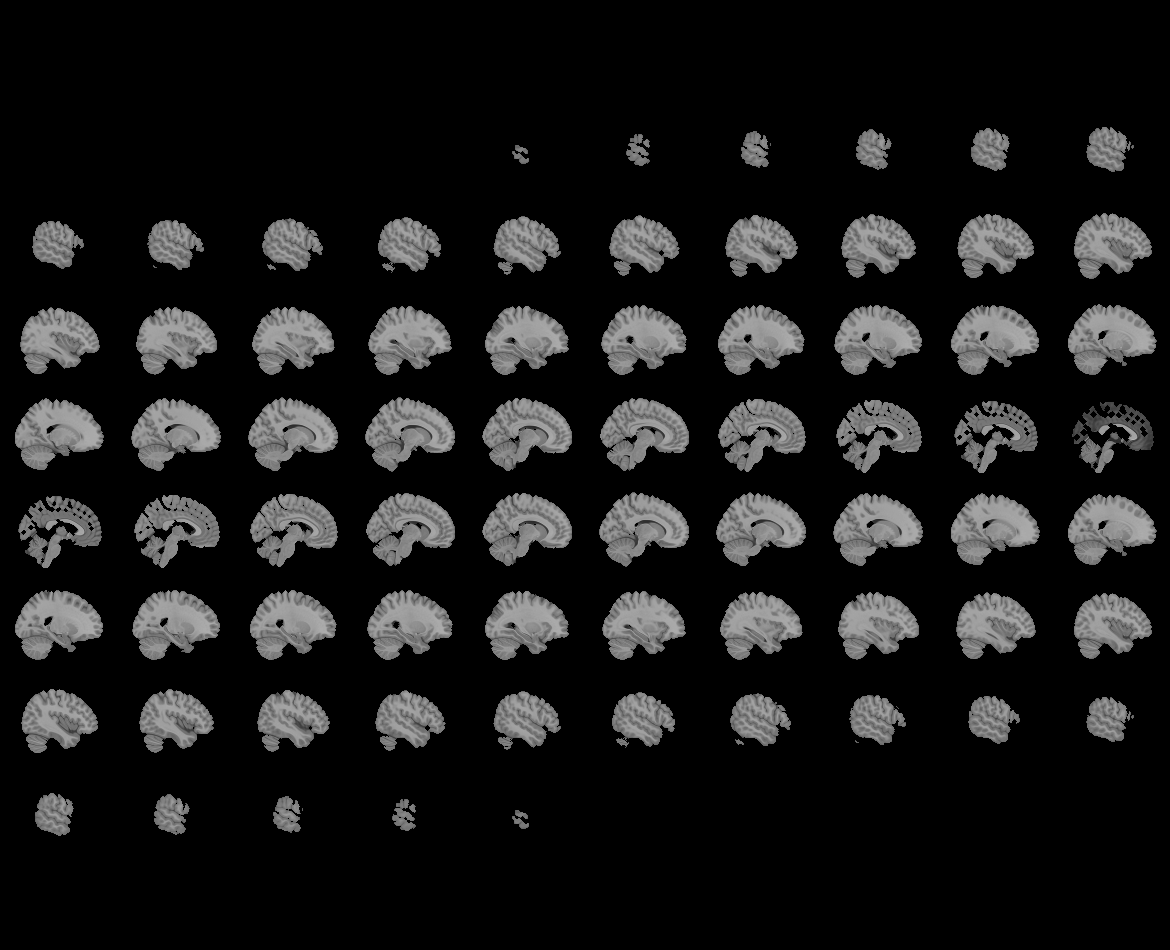
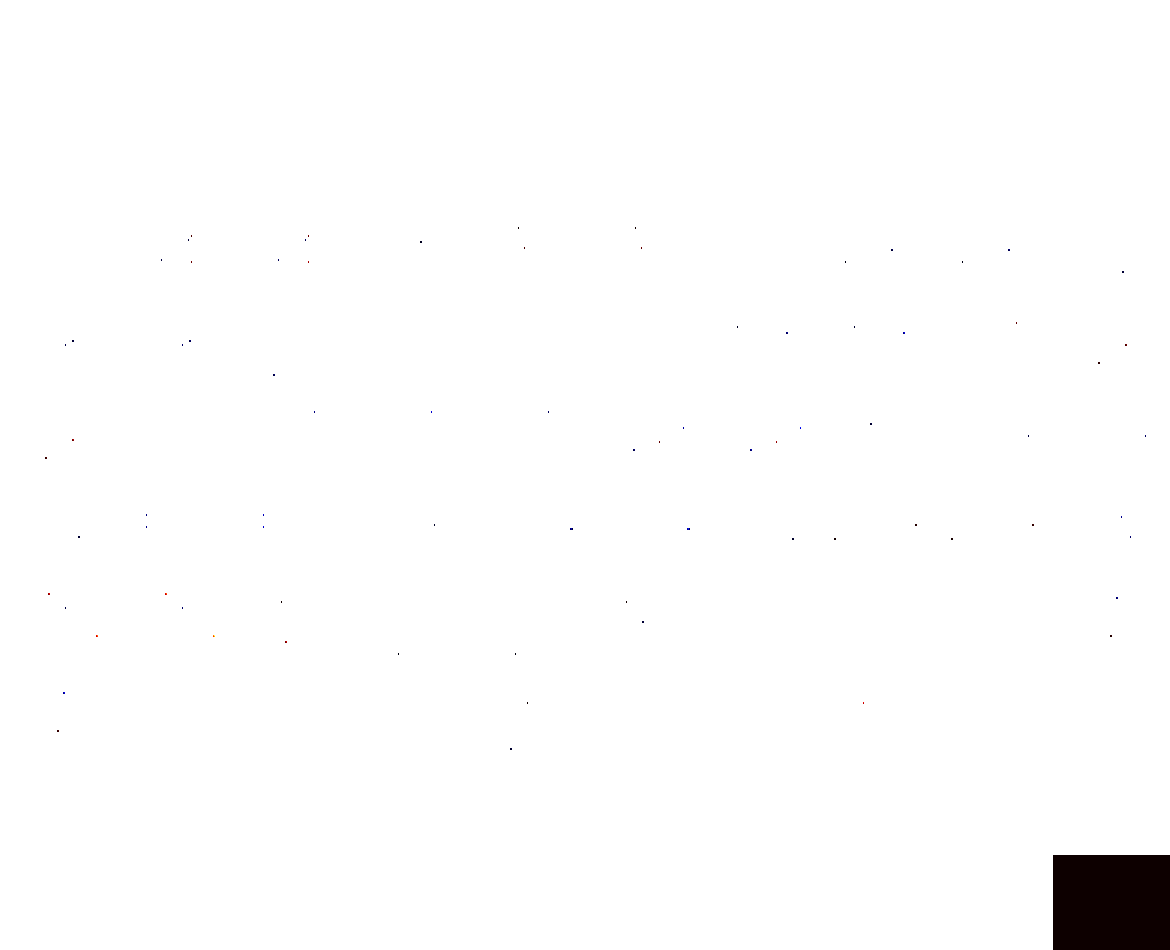

In [226]:
del hfig
hfig = plotting.view_img(decoder.coef_img_['incongruent'],
                  symmetric_cmap=True,)
hfig

## Conclusion

- We just scratched the surface of MVPA methods!
- Nonetheless, it looks like we can decode from patterns of neural activity whether a participant is currently processing an incongruent or congruent stimulus.
- The brain maps are too sparse to be interpretable.

# Have a great Winter break!!!

- Your Final Project is due by midnight on Tues, Dec. 14th.
- I will post the guideline this weekend.
- We will hold normal office hours next week, and be available to meet outside of those times to help with your final project.
